

Plot ideas:

- plot rank change to see which ones are trending worse and which are trending better
- plot dpm change / dpm to plot the growth rate (slope) over time
- plt dpm change to plot the rate * base - base, which relates to hospital capacity.


In [349]:
import datetime
from pprint import pprint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import time
import timeit

%matplotlib inline

## Data Sources

In [558]:
DATA_DIR = Path('data')


def load_owid_country_data(download=True, cache=False):
    # country covid data
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    filename = DATA_DIR / 'full_data.csv' # cached version
    if download:
        df = pd.read_csv(url)
        if cache:
            df.to_csv(filename)
    else:
        df = pd.read_csv(filename)
    
    df = df.rename(columns={'total_cases': 'cases', 
                                          'total_deaths': 'deaths',
                                          'location': 'entity'})
    # Adding country population data...
    # map UN country names to OWID country names
    u2o = dict([
         ('Bolivia (Plurinational State of)', 'Bolivia'),
         ('Brunei Darussalam', 'Brunei'),
         ('Cabo Verde', 'Cape Verde'),
         ("Côte d'Ivoire", "Cote d'Ivoire"),
         ('Curaçao', 'Curacao'),
         ('Czechia', 'Czech Republic'),
         ('Democratic Republic of the Congo', 'Democratic Republic of Congo'),
         ('Faroe Islands', 'Faeroe Islands'),
         ('Falkland Islands (Malvinas)', 'Falkland Islands'),
         ('Iran (Islamic Republic of)', 'Iran'),
         ("Lao People's Democratic Republic", 'Laos'),
         ('North Macedonia', 'Macedonia'),
         ('Northern Mariana Islands', 'Mariana Islands'),
         ('Republic of Moldova', 'Moldova'),
         ('State of Palestine', 'Palestine'),
         ('Russian Federation', 'Russia'),
         ('Republic of Korea', 'South Korea'),
         ('Eswatini', 'Swaziland'),
         ('Syrian Arab Republic', 'Syria'),
         ('China, Taiwan Province of China', 'Taiwan'),
         ('United Republic of Tanzania', 'Tanzania'),
         ('Timor-Leste', 'Timor'),
         ('United States of America', 'United States'),
         ('Holy See', 'Vatican'),
         ('Venezuela (Bolivarian Republic of)', 'Venezuela'),
         ('Viet Nam', 'Vietnam')
    ])
    # Load UN population data
    pop_df = pd.read_csv(DATA_DIR / 'WPP2019_TotalPopulationBySex.csv')
    # Use the medium variant projection for the year 2020 of total population
    pop_df = pop_df.loc[(pop_df['Time'] == 2020) & (pop_df['Variant'] == 'Medium'), ['Location', 'PopTotal']]
    # Convert Locations to match OWID country names
    pop_df['Location'] = pop_df['Location'].apply(lambda l: l if l not in u2o else u2o[l])
    pop_df['PopTotal'] = pop_df['PopTotal'] * 1000
    df = (df.merge(pop_df, how='inner', left_on='entity', right_on='Location')
          .drop(columns='Location').rename(columns={'PopTotal': 'population'}))
    df['deaths_per_million'] = df['deaths'] / df['population'] * 1e6
    df['cases_per_million'] = df['cases'] / df['population'] * 1e6
    df['new_deaths_per_million'] = df['new_deaths'] / df['population'] * 1e6
    df['new_cases_per_million'] = df['new_cases'] / df['population'] * 1e6
    
    return df


# def load_owid_deaths_per_million_since(from_days=None, filter_na=True, dataset_date='20200331'):
#     '''
#     Our World In Data deaths per million country dataset.
#     Contains deaths_per_million and days since >= 0.1 / million for countries and world.
#     dataset_date: '20200330' or '20200331'. Which file to use. The date corresponds 
#     to when the file was downloaded.
#     '''
#     if dataset_date == '20200330':
#         DAYS_COL = 'Days since total confirmed COVID-19 deaths reached 0.1 per million'
#         DPM_COL = 'Total confirmed deaths due to COVID-19 per million (deaths per million)'
#     elif dataset_date == '20200331':
#         DAYS_COL = 'Days since total confirmed deaths reached 0.1 per million (days)'
#         DPM_COL = 'Total confirmed deaths per million (deaths per million)'
        
#     # A table containing entity (countries mostly), date, days since 0.1 per million, deaths per million.
#     df = pd.read_csv(DATA_DIR / f'{dataset_date}-OWID-covid-deaths-days-since-per-million.csv')
#     df['Date'] = pd.to_datetime(df['Date'])  # convert date string

#     # filter dates for most recent 30 days, b/c data is really sparse before that
#     if from_days is not None:
#         from_date = df['Date'].max() - datetime.timedelta(days=from_days)
#         df = df.loc[df['Date'] > from_date]
        
#     # filter observations with NaN days since 0.1 per million
#     # to reduce the sparsity of the data and to fix pivot issues
#     # filter the 6 rows with nan deaths per million.
#     df = (df.loc[(df[DAYS_COL].notna()) & (df[DPM_COL].notna()), :]
#           .rename(columns={DAYS_COL: 'days_since', 
#                            DPM_COL: 'deaths_per_million',
#                            'Date': 'date',
#                            'Entity': 'entity'})
#          )
    
#     # filter observations from the current (dataset) day, b/c they might be incomplete.
#     df = df.loc[df['date'] < pd.to_datetime(dataset_date)]
    
#     return df


def load_nytimes_us_state_data(download=True, cache=False):
    '''
    nytimes dataset with cases and deaths (cummulative) for US states.
    '''
    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    filename = DATA_DIR / 'us-states.csv'
    if download:
        df = pd.read_csv(url)
        if cache:
            df.to_csv(filename)
    else:
        df = pd.read_csv(filename)
    
    df = df.rename(columns={'state': 'entity'})
    df['date'] = pd.to_datetime(df['date'])
    
    # Add state population, used to get deaths per million
    pop_df = (pd.read_csv(DATA_DIR / 'nst-est2019-alldata.csv')
              .loc[lambda d: d['SUMLEV'] == 40, ]
             )
    df = (df.merge(pop_df, how='inner', left_on='entity', right_on='NAME')
           .loc[:, ['date', 'entity', 'cases', 'deaths', 'POPESTIMATE2019']]
           .rename(columns={'POPESTIMATE2019': 'population'})
          )
    
    # Add daily change
    grouped = df.groupby(['entity'])
    df['new_cases'] = grouped['cases'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] - w.iloc[0]))
    df['new_deaths'] = grouped['deaths'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] - w.iloc[0]))
    df['cases_daily_growth_rate'] = grouped['cases'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] / w.iloc[0]))
    df['deaths_daily_growth_rate'] = grouped['deaths'].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[1] / w.iloc[0]))
    
    df['deaths_per_million'] = df['deaths'] / df['population'] * 1e6
    df['cases_per_million'] = df['cases'] / df['population'] * 1e6
    df['new_deaths_per_million'] = df['new_deaths'] / df['population'] * 1e6
    df['new_cases_per_million'] = df['new_cases'] / df['population'] * 1e6
#     mer = mer.loc[mer['deaths_per_million'] >= 0.1, :]  # ignore anything smaller than 0.1 DPM
#     days_since = mer.groupby(['entity'])['deaths_per_million'].transform(lambda s: list(range(len(s))))
#     mer = mer.assign(days_since=days_since)
    return df
   

def make_nday_ratio(df, col, n=1):
    return df.groupby(['entity'])[col].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] / w.iloc[0]))
    
    
def make_nday_diff(df, col, n=1):
    return df.groupby(['entity'])[col].transform(
        lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))
    

def filter_before_first(df, col, thresh):
    '''
    Within each entity, values are set to np.nan when they fall below the
    threshold and occur before the first day that
    value >= threshold.
    '''
    def filt(s, thresh):
        idx = (s >= thresh).cumsum() > 0
        return np.where(idx, s, np.nan)
    return df.groupby(['entity'])[col].transform(filt, thresh=thresh)


def make_days_since(df, col, thresh):
    '''
    Days since first day the value of col >= thresh. 
    Example of column and threshold from data journalists:
    - days since deaths per million reached 0.1 deaths per million
      (OWID deaths per million trajectories).
    - days since 3 daily deaths first recorded (FT daily deaths trajectory)
      https://twitter.com/jburnmurdoch/status/1245466020053164034
      
    Example usage:
        df['days_since'] = make_days_since(df, 'deaths_per_million', 0.1)
    '''
    # >>> a = np.array([[1,1,1,1],[1,2,1,2],[1,1,2,2],[2,2,2,2]]).astype(float)
    # >>> a
    # array([[1., 1., 1., 1.],
    #        [1., 2., 1., 2.],
    #        [1., 1., 2., 2.],
    #        [2., 2., 2., 2.]])
    # >>> b = ((a > 1).cumsum(axis=1) > 0).cumsum(axis=1).astype(float) - 1
    # >>> b[b < 0] = np.nan
    # >>> b
    # array([[nan, nan, nan, nan],
    #        [nan,  0.,  1.,  2.],
    #        [nan, nan,  0.,  1.],
    #        [ 0.,  1.,  2.,  3.]])
    def days_since(s, thresh):
        '''s: a Series containing the values of col for an entity ordered by date'''
        days = ((s >= thresh).cumsum() > 0).cumsum().astype(float) - 1
        days[days < 0] = np.nan
        return days
        
    return df.groupby(['entity'])[col].transform(days_since, thresh=thresh)


#### Figure out how to map UN Locations to OWID Entities

In [503]:
def map_owid_to_un_pop(mer=None):
    '''
    Print where owid countries and un countries do not line up.
    Visually inspect to build a mapping so that all OWID countries map.
    '''
    # convert UN country names to OWID country names.
    # 'Guernsey': None,  # No population info in UN csv.
    # 'International': None,  # Not a country. :-)
    # 'Jersey': None, # Guernsey and Jersey are british channel islands
    # 'Kosovo': None, # Republic of Kosovo
    u2o = dict([
         ('Bolivia (Plurinational State of)', 'Bolivia'),
         ('Brunei Darussalam', 'Brunei'),
         ('Cabo Verde', 'Cape Verde'),
         ("Côte d'Ivoire", "Cote d'Ivoire"),
         ('Curaçao', 'Curacao'),
         ('Czechia', 'Czech Republic'),
         ('Democratic Republic of the Congo', 'Democratic Republic of Congo'),
         ('Faroe Islands', 'Faeroe Islands'),
         ('Falkland Islands (Malvinas)', 'Falkland Islands'),
         ('Iran (Islamic Republic of)', 'Iran'),
         ("Lao People's Democratic Republic", 'Laos'),
         ('North Macedonia', 'Macedonia'),
         ('Northern Mariana Islands', 'Mariana Islands'),
         ('Republic of Moldova', 'Moldova'),
         ('State of Palestine', 'Palestine'),
         ('Russian Federation', 'Russia'),
         ('Republic of Korea', 'South Korea'),
         ('Eswatini', 'Swaziland'),
         ('Syrian Arab Republic', 'Syria'),
         ('China, Taiwan Province of China', 'Taiwan'),
         ('United Republic of Tanzania', 'Tanzania'),
         ('Timor-Leste', 'Timor'),
         ('United States of America', 'United States'),
         ('Holy See', 'Vatican'),
         ('Venezuela (Bolivarian Republic of)', 'Venezuela'),
         ('Viet Nam', 'Vietnam')
    ])

    if mer is None:
        pop_df = pd.read_csv(DATA_DIR / 'WPP2019_TotalPopulationBySex.csv')
        # Convert Locations to match OWID country names
        pop_df['Location'] = pop_df['Location'].apply(lambda l: l if l not in u2o else u2o[l])
        # Use the medium variant projection for the year 2020 of total population
        pop_df = pop_df.loc[(pop_df['Time'] == 2020) & (pop_df['Variant'] == 'Medium'), ['Location', 'PopTotal']]
        df = download_owid_country_data()
        mer = df.merge(pop_df, how='outer', left_on='entity', right_on='Location')
    
    
    print('OWID entity not found in UN pop Location')
    print(mer.loc[mer['Location'].isna(), 'entity'].unique())
    print('UN pop Location not found in OWID entity')
    print(mer.loc[mer['entity'].isna(), 'Location'].unique())
    return mer

mer = map_owid_to_un_pop()
mer

OWID entity not found in UN pop Location
[]
UN pop Location not found in OWID entity
['Africa' 'African Group' 'African Union' 'African Union: Central Africa'
 'African Union: Eastern Africa' 'African Union: Northern Africa'
 'African Union: Southern Africa' 'African Union: Western Africa'
 'African, Caribbean and Pacific (ACP) Group of States' 'American Samoa'
 'Andean Community' 'Asia' 'Asia-Pacific Economic Cooperation (APEC)'
 'Asia-Pacific Group' 'Association of Southeast Asian Nations (ASEAN)'
 'Australia/New Zealand' 'BRIC' 'BRICS' 'Belt-Road Initiative (BRI)'
 'Belt-Road Initiative: Africa' 'Belt-Road Initiative: Asia'
 'Belt-Road Initiative: Europe'
 'Belt-Road Initiative: Latin America and the Caribbean'
 'Belt-Road Initiative: Pacific' 'Black Sea Economic Cooperation (BSEC)'
 'Bolivarian Alliance for the Americas (ALBA)'
 'Bonaire, Sint Eustatius and Saba' 'Caribbean'
 'Caribbean Community and Common Market (CARICOM)' 'Central America'
 'Central Asia' 'Central European Free 

,date,entity,new_cases,new_deaths,cases,deaths,population,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million,Location,PopTotal
0,2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0,0.0,Afghanistan,38928.341
1,2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0,0.0,Afghanistan,38928.341
2,2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0,0.0,Afghanistan,38928.341
3,2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0,0.0,Afghanistan,38928.341
4,2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,0.0,0.0,0.0,0.0,Afghanistan,38928.341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western Europe,196146.321
8362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western European and Others Group (WEOG),923721.644
8363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Western Sahara,597.330
8364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,World Bank Regional Groups (developing only),6528762.227


## Plot Vermont Coronavirus Cases vs Date

In [504]:
# load data
# df['days_since'] = make_days_since(df, 'deaths_per_million', 0.1)
states_df = load_nytimes_us_state_data(download=False, cache=True)
countries_df = load_owid_country_data(download=False, cache=True)


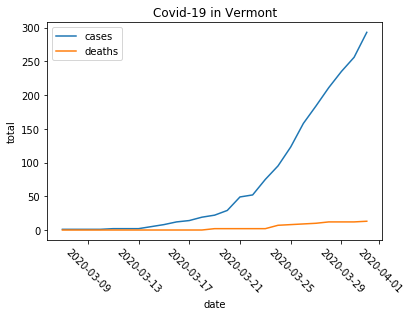

,date,entity,cases,deaths,population,new_cases,new_deaths,cases_daily_growth_rate,deaths_daily_growth_rate,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million
1147,2020-03-29,Vermont,235,12,623989,24.0,0.0,1.113744,1.000000,19.231108,376.609203,0.000000,38.462216
1148,2020-03-30,Vermont,256,12,623989,21.0,0.0,1.089362,1.000000,19.231108,410.263642,0.000000,33.654439
1149,2020-03-31,Vermont,293,13,623989,37.0,1.0,1.144531,1.083333,20.833701,469.559560,1.602592,59.295917


In [505]:
df = states_df.loc[states_df['entity'] == 'Vermont', :]
plt.plot(df['date'], df['cases'], label='cases')
plt.plot(df['date'], df['deaths'], label='deaths')
plt.xticks(rotation=-45)
plt.ylabel('total')
plt.xlabel('date')
plt.title('Covid-19 in Vermont')
plt.legend()
plt.show()
df.tail(3)

## Trajectory Plots for deaths or deaths per million vs Date or Days Since

An excellent example of a similar plot of log(DPM) vs days since 0.1 DPM is https://ourworldindata.org/grapher/covid-deaths-days-since-per-million. It visually shows which countries are on similar trajectories, but makes it hard to compare the timeline of when interventions in countries are happening and what their outbreak looked like when those interventions were put in place.

Plotting log(DPM) vs date makes it harder to see the similarities of trajectories (though many of the trajectories look similar. Harder to plot those awesome sloped lines that say "doubles every 2 days", "doubles every 3 days", "doubles every 5 days", etc. Maybe an inset protractor-like graphic showing the doubling times.


### Hospital Beds

What is the medical capacity required to handle the peak of the infection. It depends on how full the beds are, at what rate new patients are coming in, and what rate old patients are leaving (death or recovery).

When plotted on a log(deaths per million) scale, what "slope" can a given amount of medical capacity (ICU beds, ventilators, healthcare workers, PPE, etc.) handle? Assume that the daily change in deaths per million is proportional (accounting for lag and growth changes) to incoming icu cases. For a steady state between incoming ICU cases and outgoing ICU cases (death and recovery), outgoing ICU cases (deaths and recoveries) must equal incoming ICU cases and therefore be proportional to delta deaths per million. And delta deaths per million relates deaths per million * slope. 

Why should we care? As deaths per million goes up, the slope must decrease to match hospital capacity. That means the government response must be stronger and more burdensome.
 
If delta_dpm exceeds this amount, than the number of incoming patients exceeds outgoing and must be absorbed by  available medical capacity. If delta_dpm is less than this amount, the number of incoming patients is less than the number of outgoing patients, and available hospital capacity increases.

In [597]:
# Seasonal Flu Death Source
# https://www.cdc.gov/flu/about/burden/index.html
# seasons: 2010-2011, 2011-2012, 2012-2013, 2013-2014, 2014-2015, 2015-2016, 2016-2017, 2017-2018
seasonal_flu_deaths = np.array([37000, 12000, 43000, 38000, 51000, 23000, 38000, 61000])
# US Population Source
# https://www.worldometers.info/world-population/us-population/
us_pop = 331000000 # estimated 2020 population
seasonal_flu_dpm = seasonal_flu_deaths.mean() / us_pop * 1e6
bad_flu_dpm = seasonal_flu_deaths.max() / us_pop * 1e6
print(f'seasonal_flu_dpm: {seasonal_flu_dpm}, bad_flu_dpm: {bad_flu_dpm}')

# def plot_trajectories(df, rank=False, top_n=None, value_col='deaths',
#                       days_since_thresh=None,
#                       per_million=False, daily=None):
#     '''
#     df: columns: date, deaths, cases, population
#     days_since_thresh: if not None, plot the days since the first day that the values >= days_since_thresh.
#     Otherwise, plot the date.
#     top_n: int > 0. Display the n highest dpm trajectories.
#     daily: If None, plot cumulative numbers. 
#     If 'diff', plot daily change from one day to the next. 
#     If 'ratio', plot the daily growth rate, i.e. the ratio of consecutive days.
#     '''
    
#     # Transform values column
#     if per_million:
#         values = df[value_col]
#         values = values / df['population']
#         value_col += '_per_million'
#         df[value_col] = values

#     if daily == 'diff':
#         values = df.groupby(['entity'])[value_col].transform(
#             lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))
#         value_col += '_diff_per_day'
#         df[value_col] = values
#     elif daily == 'ratio':
#         values = df.groupby(['entity'])[value_col].transform(
#             lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] / w.iloc[0]))
#         value_col += '_growth_per_day'
#         df[value_col] = values
        
#     # remove days without values
#     df = df.loc[df[value_col].notna(), :]  

#     # pivot table so axis 0 (index) is date or days_since and axis 1 (columns) is the entity and values are DPM
#     if days_since_thresh is not None:
#         df = (df.assign(days_since=make_days_since(df, value_col, days_since_thresh))
#               .loc[lambda d: d['days_since'].notna(), :])  # remove observation before the first day
#         index_col = 'days_since'
#     else:
#         index_col = 'date'
        
#     piv = df.pivot(index=index_col, columns='entity', values=value_col)
# #     print('piv.shape:', piv.shape)
#     piv = piv.loc[piv.notnull().any(axis=1), :]  # remove rows with all null values
# #     print('piv.shape:', piv.shape)
# #     print('piv.head:', piv.head())
#     # pivot == 'days_since' maybe does not play well with bad_flu.
#     if days_since_thresh is None:
#         piv = piv.assign(seasonal_flu=seasonal_flu_dpm, bad_flu=bad_flu_dpm)
    
#     # entities ranked by each day, or by each day since 0.1.
#     if rank:
#         piv = piv.rank(axis=1, method='average', ascending=False)
  
#     # Plot in sorted order by most recent DPM
#     # In date order, the last column is dense (and the max value of each entity).
#     # In days since order, take the max value of each entity.
#     sort_idx = np.argsort(piv.max(axis=0))
#     if not rank:
#         # plot deaths per million from largest to smallest
#         sort_idx = sort_idx[::-1]
        
#     entities_sorted_by_value = piv.columns.values[sort_idx]
#     top_locs = (df.loc[:, ['entities', 'population']]
#                 .drop_duplicates()
#                 .sort_values(by='population', ascending=False)['entities']).iloc[:10]
# #     top_locs = entities_sorted_by_value[:top_n]
# #     top_locs = ['New York', 'Louisiana', 'Washington', 'California', 'Vermont']

#     # Figure
#     fig, ax = plt.subplots(figsize=(14,10))
#     for i, country in enumerate(entities_sorted_by_value):
#         if country in top_locs:
#             linewidth = 2.0
#             alpha = 1.0
#             label = f'{country}[{i+1}]'
#         else:
#             linewidth = 1.0
#             alpha = 0.5
#             label = None
            
#         if rank:
#             plt.plot(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)
#         else:
# #             plt.plot(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)            
#             plt.semilogy(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)

#     if rank:
#         ax.invert_yaxis()
        
#     ylabel = value_col
#     if rank:
#         ylabel += ' (rank)'
#     else:
#         ylabel += ' (log scale)'
#     plt.ylabel(ylabel)
    
#     if days_since_thresh is None:
#         plt.xlabel('Date')
#     else:
#         plt.xlabel(f'Days since {days_since_thresh:.2} {value_col}')
      
#     title = f'{value_col}{"" if not rank else " (rank)"} in Each Location' 
#     title += ' Over Time' if not days_since_col else f' Since {days_since_thresh:.2} {value_col}'
#     plt.title(title)
    
#     # pivot == 'days_since' maybe does not play well with bad_flu in the data.
#     if days_since_col and not rank:
#         plt.axhline(seasonal_flu_dpm, linestyle='--', label='seasonal flu')
#         plt.axhline(bad_flu_dpm, color='orange', linestyle='--', label='bad flu')
        
#     plt.xticks(rotation=-45)
#     plt.legend()
#     plt.show()
#     return piv


def plot_trajectories(df, index_col='date', values_col='deaths', thresh=None, rank=False, top_n=None):
    '''
    df: columns: date, deaths, cases, population
    index_col: either date or days_since. This is the pivot index.
    values_col: e.g. deaths, deaths_per_million, deaths_per_day, deaths_per_million_per_day
    thresh: if not None, remove observations with df[values_col] < thresh.
    rank: plot the ranks of the values within each day.
    top_n: int > 0. Display the n highest dpm trajectories.
    '''
    
    # remove obsevations without values
    df = df.loc[df[values_col].notna(), :] 
    # remove observations without index value 
    # for example, days that happen before the first day of the days_since column
    df = df.loc[df[index_col].notna(), :]

    # Pivot to a table with country/entity columns and date/days_since rows
    piv = df.pivot(index=index_col, columns='entity', values=values_col)
    piv = piv.loc[piv.notnull().any(axis=1), :]  # remove rows with all null values

    # entities ranked by each day, or by each day since 0.1.
    if rank:
        piv = piv.rank(axis=1, method='average', ascending=False)
  
    # Plot countries in order. Sort by most recent value for each entity.
    sort_idx = np.argsort(piv.apply(lambda s: s[s.notna()].iloc[-1], axis=0))
    # In date order, the last row contains the most recent value
    # In days_since order, the most recent value depends on the length of the outbreak.
    piv.apply(lambda s: s[s.notna()].iloc[-1], axis=0)
    sort_idx = np.argsort(piv.max(axis=0))
    if not rank:
        # plot deaths per million from largest to smallest
        sort_idx = sort_idx[::-1]
        
    entities_sorted_by_value = piv.columns.values[sort_idx]
    
    # Emphasize the top N trajectories 
#     top_locs = list((df.loc[:, ['entity', 'population']]
#                 .drop_duplicates()
#                 .sort_values(by='population', ascending=False)['entity']).iloc[:top_n])
#     print('top_locs', top_locs)
    top_locs = entities_sorted_by_value[:top_n]
#     top_locs = ['New York', 'Louisiana', 'Washington', 'California', 'Vermont']
    ft_list = ['Spain', 'Italy', 'China', 'United States', 'United Kingdom', 'France', 'Germany',
               'South Korea', 'India', 'Canada']
    top_locs = ft_list
    # Figure
    fig, ax = plt.subplots(figsize=(14,10))
    for i, country in enumerate(entities_sorted_by_value):
        if country in top_locs:
            linewidth = 2.0
            alpha = 1.0
            label = f'{country}[{i+1}]'
        else:
            continue
            linewidth = 1.0
            alpha = 0.5
            label = None
            
        if rank or 'ratio' in values_col:
            plt.plot(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)
        else:
#             plt.plot(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)            
            plt.semilogy(piv.index, piv[country], label=label, linewidth=linewidth, alpha=alpha)

    if rank:
        ax.invert_yaxis()
        
    ylabel = values_col
    if rank:
        ylabel += ' (rank)'
    else:
        ylabel += ' (log scale)'
    plt.ylabel(ylabel)
    
    if index_col == 'date':
        plt.xlabel('Date')
    elif index_col == 'days_since':
        plt.xlabel(f'Days since outbreak began')
      
    title = f'{values_col}{"" if not rank else " (rank)"} in Each Location' 
    title += ' Over Time' if not days_since_col else f' Since Outbreak Began'
    plt.title(title)
    
    # pivot == 'days_since' maybe does not play well with bad_flu in the data.
    if values_col == 'deaths_per_million' and not rank:
        plt.axhline(seasonal_flu_dpm, linestyle='--', label='seasonal flu')
        plt.axhline(bad_flu_dpm, color='orange', linestyle='--', label='bad flu')
        
    plt.xticks(rotation=-60)
    plt.legend()
    plt.show()
    return piv

seasonal_flu_dpm: 114.42598187311178, bad_flu_dpm: 184.29003021148037


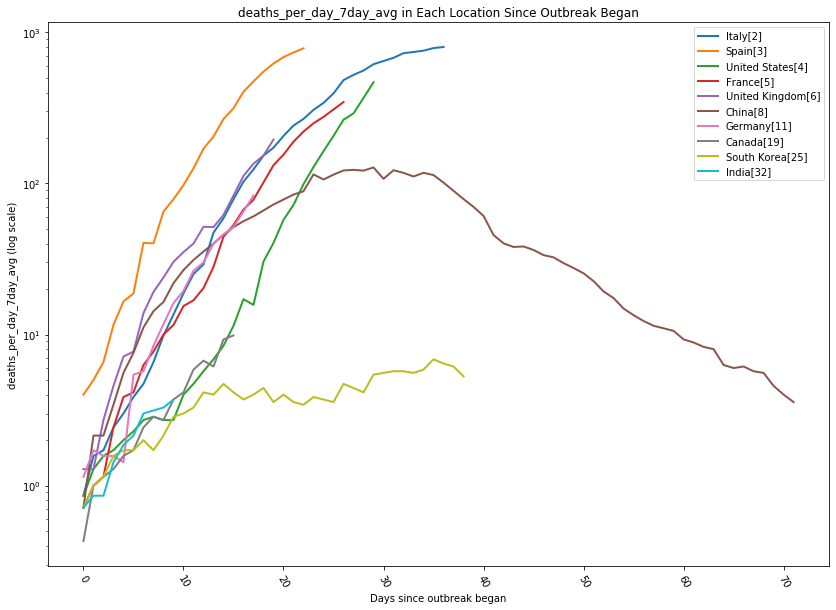

entity,Albania,Algeria,Andorra,Argentina,Australia,Austria,Belgium,Bolivia,Bosnia and Herzegovina,Brazil,...,Sweden,Switzerland,Taiwan,Thailand,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,World
days_since,,,,,,,,,,,,,,,,,,,,,
0.0,1.000000,1.142857,0.428571,1.285714,0.714286,2.142857,0.428571,0.428571,1.428571,0.571429,...,1.000000,0.857143,0.428571,0.428571,NaN,0.714286,0.428571,1.285714,0.857143,0.714286
1.0,1.142857,1.142857,0.428571,2.000000,1.000000,3.142857,0.428571,0.857143,NaN,0.857143,...,1.142857,1.428571,0.428571,0.428571,1.285714,0.857143,0.571429,1.285714,1.285714,2.142857
2.0,1.142857,1.571429,0.571429,2.142857,0.857143,3.857143,0.428571,1.000000,NaN,1.571429,...,1.285714,1.571429,0.428571,0.428571,3.000000,1.142857,NaN,2.714286,1.571429,2.142857
3.0,1.142857,1.857143,0.857143,2.285714,1.000000,4.285714,0.571429,NaN,NaN,2.571429,...,1.285714,1.714286,NaN,0.571429,4.285714,1.428571,NaN,4.571429,1.714286,3.428571
4.0,1.428571,1.714286,1.142857,2.857143,1.285714,6.571429,0.571429,NaN,NaN,3.571429,...,2.142857,2.285714,NaN,0.571429,5.285714,NaN,NaN,7.142857,2.000000,5.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2248.428571
68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2501.428571
69.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2710.714286


In [608]:
# df = states_df
df = countries_df
values = 'deaths'

values_per_million = values + '_per_million'
df[values_per_million] = df[values] / df['population'] * 1e6

values_per_day = values + '_per_day'
df[values_per_day] = df.groupby(['entity'])[values].transform(
    lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))

# FT: 7-day rolling average of daily change in deaths
# https://www.ft.com/coronavirus-latest
values_per_day_7day_avg = values_per_day + '_7day_avg'
df[values_per_day_7day_avg] = (df.groupby(['entity'])[values_per_day]
                                           .transform(lambda s: s.rolling(7).mean()))                                   

# Per capita alternative to unnormalized FT values
values_per_million_per_day_7day_avg = values_per_million_per_day + '_7day_avg'
df[values_per_million_per_day_7day_avg] = (df.groupby(['entity'])[values_per_million_per_day]
                                           .transform(lambda s: s.rolling(7).mean()))                                   

values_per_week = values + '_per_week'
df[values_per_week] = df.groupby(['entity'])[values].transform(
    lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] - w.iloc[0]))

values_per_million_per_day = values_per_million + '_per_day'
df[values_per_million_per_day] = df.groupby(['entity'])[values_per_million].transform(
    lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] - w.iloc[0]))

values_per_million_per_week = values_per_million + '_per_week'
df[values_per_million_per_week] = df.groupby(['entity'])[values_per_million].transform(
    lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] - w.iloc[0]))

values_ratio_per_day = values + '_ratio_per_day'
df[values_ratio_per_day] = df.groupby(['entity'])[values].transform(
    lambda s: s.rolling(2).apply(lambda w: w.iloc[-1] / w.iloc[0]))

values_ratio_per_week = values + '_ratio_per_week'
df[values_ratio_per_week] = df.groupby(['entity'])[values].transform(
    lambda s: s.rolling(8).apply(lambda w: w.iloc[-1] / w.iloc[0]))

top_n = 20; rank = False
index_col, thresh, values_col = ('days_since', 0.1, 'deaths_per_million')
index_col, thresh, values_col = ('days_since', 1.0, 'deaths_per_million')
index_col, thresh, values_col = ('days_since', 3, 'deaths_per_day')
index_col, thresh, values_col = ('days_since', 20, 'deaths_per_week')
index_col, thresh, values_col = ('date', 0.1, 'deaths_per_million')
index_col, thresh, values_col = ('date', 1.1, 'deaths_ratio_per_week')
index_col, thresh, values_col = ('days_since', 1.1, 'deaths_ratio_per_week')
index_col, thresh, values_col = ('days_since', .01, 'deaths_per_million_per_week')
index_col, thresh, values_col, days_since_col = ('days_since', 3, 'deaths_per_million_per_day_7day_avg', 
                                                 'deaths_per_day')
index_col, thresh, values_col, days_since_col = ('days_since', 3, 'deaths_per_day_7day_avg', 
                                                 'deaths_per_day')

# index_col, thresh, values_col = ('days_since', .01, 'deaths_per_million_per_day')
# index_col, thresh, values_col = ('date', .02, 'deaths_per_million_per_week')

# index_col, thresh, values_col = ('date', 3.0, 'deaths_per_day')
if index_col == 'days_since':
    df['days_since'] = make_days_since(df, days_since_col, thresh)
elif index_col == 'date' and thresh is not None:
    # ignore values before the first value that meets the threshold
    df[values_col] = filter_before_first(df, values_col, thresh)
piv = plot_trajectories(df, index_col=index_col, values_col=values_col, thresh=thresh, rank=rank, top_n=top_n)
piv
# piv = plot_trajectories(df, pivot='date', rank=False, top_n=top_n)
# piv = plot_trajectories(df, pivot='date', rank=True, top_n=top_n)


In [546]:
piv
df[df['entity']=='Angola']

,date,entity,cases,deaths,population,new_cases,new_deaths,cases_daily_growth_rate,deaths_daily_growth_rate,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million,deaths_per_day,deaths_ratio_per_day,days_since


In [488]:
piv[piv < days_since_thresh].any()
piv['Angola'].head(20)
df[df['entity']=='Angola'].head(20)

,date,entity,new_cases,new_deaths,cases,deaths,population,deaths_per_million,cases_per_million,new_deaths_per_million,new_cases_per_million,deaths_per_day,deaths_ratio_per_day
214,2020-03-22,Angola,2,0,2,0,32866268.0,0.000000,0.060853,0.000000,0.060853,NaN,NaN
215,2020-03-23,Angola,0,0,2,0,32866268.0,0.000000,0.060853,0.000000,0.000000,0.0,NaN
216,2020-03-24,Angola,0,0,2,0,32866268.0,0.000000,0.060853,0.000000,0.000000,0.0,NaN
217,2020-03-25,Angola,0,0,2,0,32866268.0,0.000000,0.060853,0.000000,0.000000,0.0,NaN
218,2020-03-26,Angola,0,0,2,0,32866268.0,0.000000,0.060853,0.000000,0.000000,0.0,NaN
219,2020-03-27,Angola,1,0,3,0,32866268.0,0.000000,0.091279,0.000000,0.030426,0.0,NaN
220,2020-03-28,Angola,1,0,4,0,32866268.0,0.000000,0.121705,0.000000,0.030426,0.0,NaN
221,2020-03-29,Angola,0,0,4,0,32866268.0,0.000000,0.121705,0.000000,0.000000,0.0,NaN
222,2020-03-30,Angola,3,2,7,2,32866268.0,0.060853,0.212984,0.060853,0.091279,2.0,inf
223,2020-03-31,Angola,0,0,7,2,32866268.0,0.060853,0.212984,0.000000,0.000000,0.0,1.0


In [480]:
plot_trajectories(col='date_rank', dpm_filter=1.0,
                 top_n=100)

TypeError: plot_trajectories() got an unexpected keyword argument 'col'